# Non-linear regression

##### Libraries

In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as ss

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Goals of this lecture
 
- Non-linear relationships: why do we care?  
   - Quick "tour" of common non-linear functions. 
- Accommodating non-linear relationships in the **linear regression equation**.  
   - Interpreting non-linear models.

## Introducing non-linearity

> A **non-linear relationship** between two variables is one for which the slope of the curve showing the relationship changes as the value of one of the variables changes.

I.e., not just a line!

### Review: linear regression assumes linearity

$Y = \beta_0 + \beta_1X_1 * ... \beta_nX_n + \epsilon$

Text(0, 0.5, 'Y')

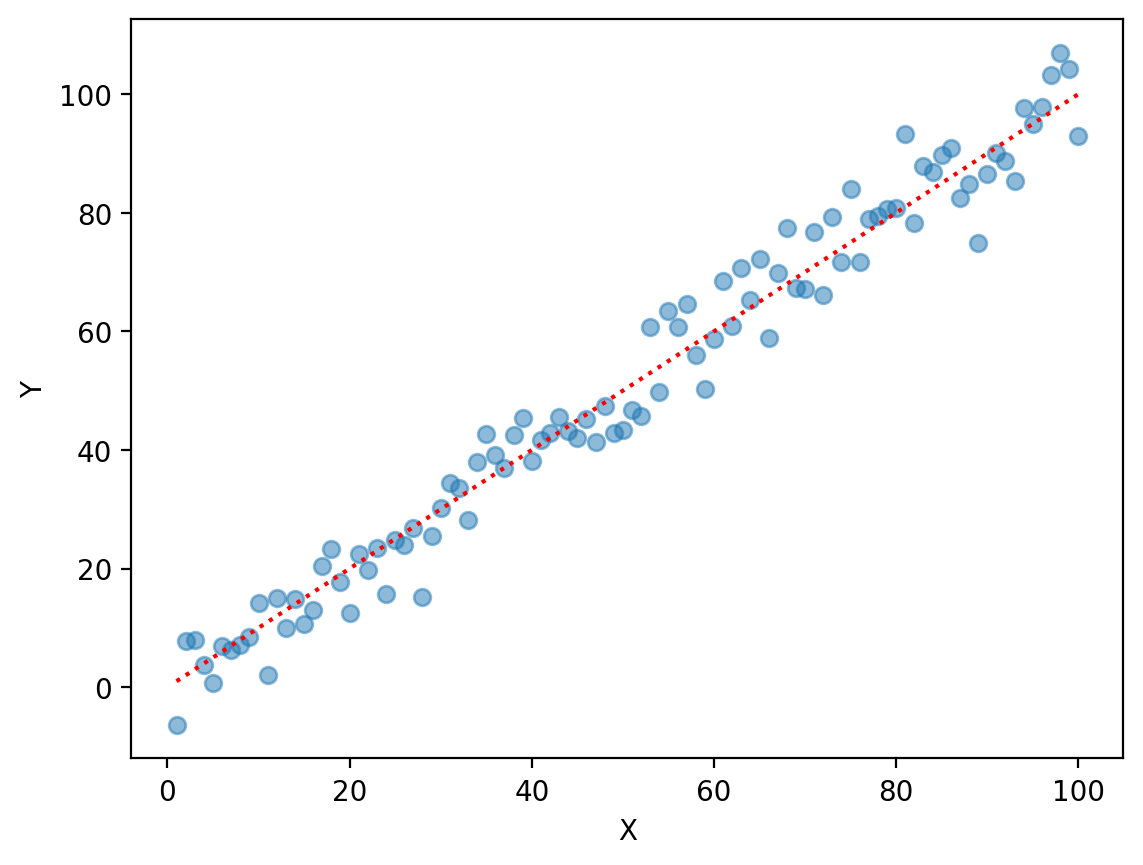

In [3]:
X = np.arange(1, 101)
y = X + np.random.normal(scale = 5, size = 100)
plt.scatter(X, y, alpha = .5)
plt.plot(X, X, color = "red", linestyle = "dotted")
plt.xlabel("X")
plt.ylabel("Y")

### Non-linear relationships are common

Although we often *assume* linearity, non-linear relationships are common in the real world.

Examples:

- Word frequency distribution ([power law](https://en.wikipedia.org/wiki/Power_law)).
- GDP growth (often modeled as [exponential](https://foresightguide.com/exponential-growth-e-curves/#:~:text=Economic%20growth%20is%20one%20good,average%20of%209%25%20in%20China.)). 
- Some areas of population growth (often modeled as [logistic](https://www.khanacademy.org/science/ap-biology/ecology-ap/population-ecology-ap/a/exponential-logistic-growth)). 

Because of this, it's important to know when the assumption of linearity is not met.

### Tour of non-linearity

> Non-linear functions are all non-linear in their own way...

It's helpful to build **visual intuition** for what different non-linear functions look like.

#### Non-linear function 1: Quadratic

The quadratic function looks like:

$f(X) = \beta_2X^2 + \beta_1X^1 + \beta_0$

**Feel free to change the coefficients (or the range of $X$) to see the effect on $Y$.**

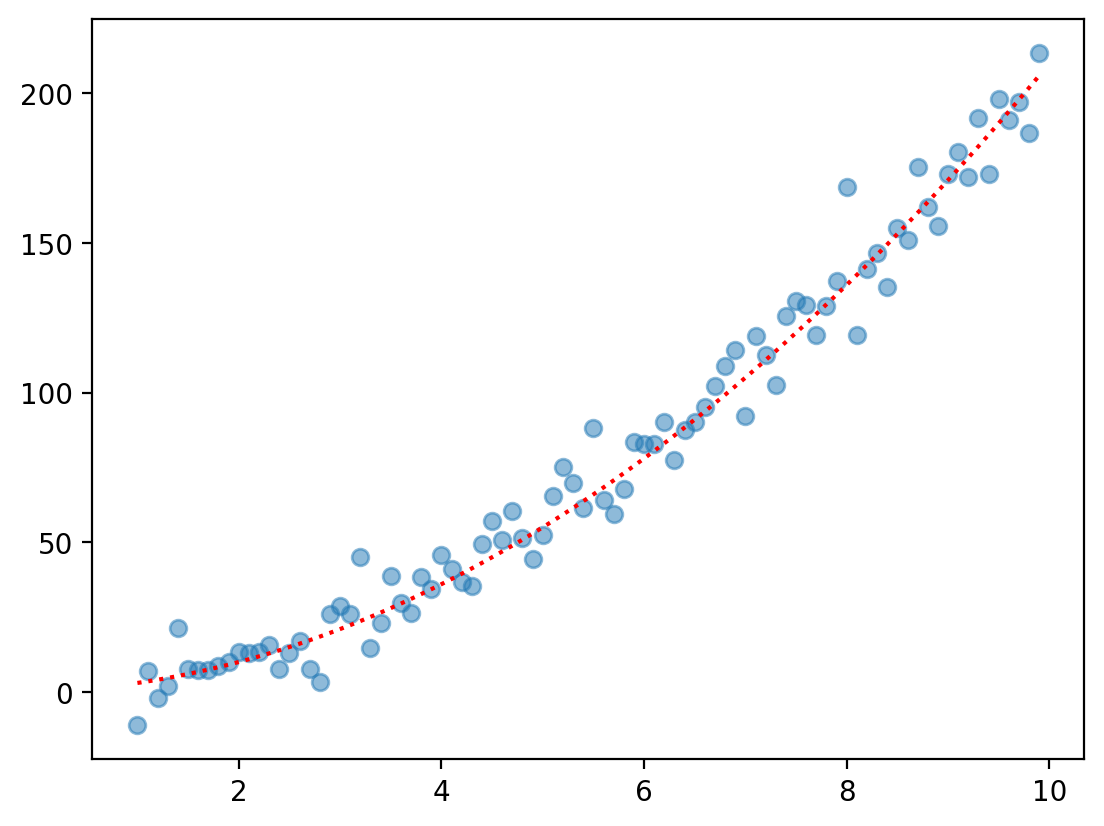

In [4]:
X = np.arange(1, 10, .1)
b0, b1, b2 = 0, 1, 2
y = b0 + b1 * X + b2 * X ** 2 
y_err = np.random.normal(scale = 10, size = len(X))
plt.scatter(X, y + y_err, alpha = .5)
plt.plot(X, y, linestyle = "dotted", color = "red")

#### Non-linear function 2: Logarithmic

A logarithmic function is just the `log` of $X$.

$f(X) = \beta_0 + \beta_1 * \log(X)$

**Feel free to change the coefficients (or the range of $X$) to see the effect on $Y$.**

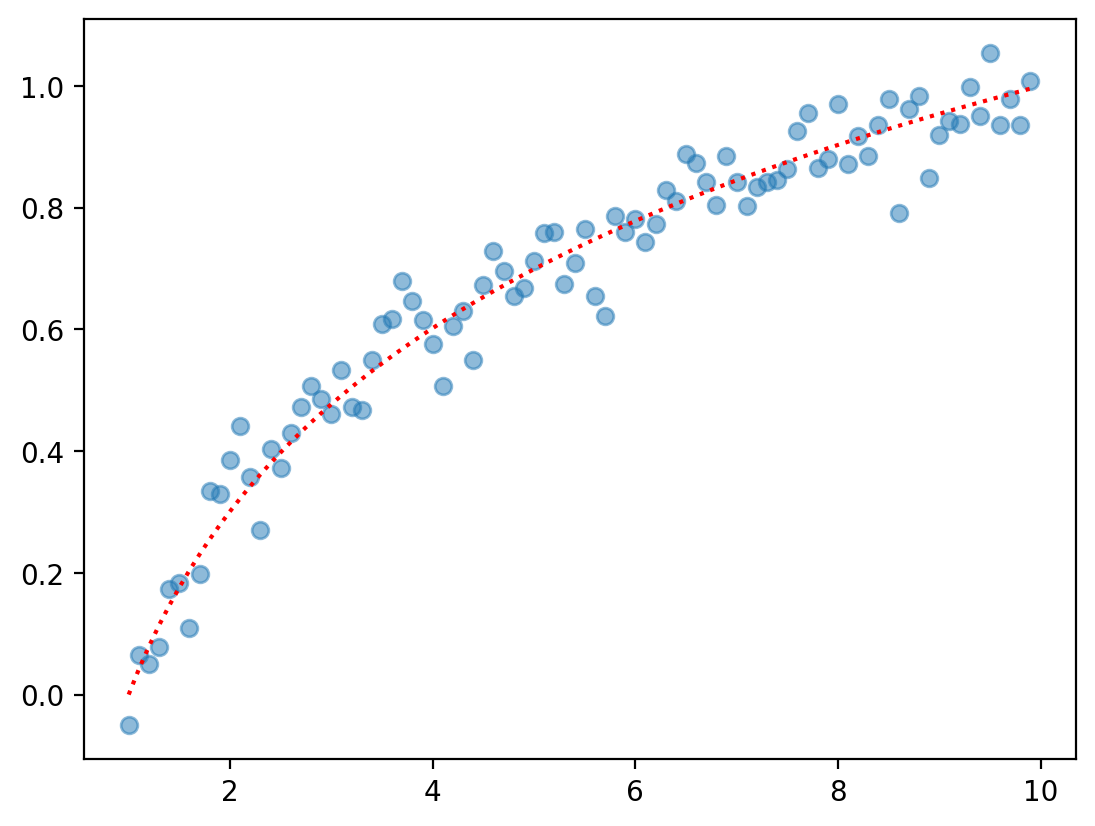

In [5]:
X = np.arange(1, 10, .1)
b0, b1 = 0, 1
y = b0 + b1 * np.log10(X)
y_err = np.random.normal(scale = .05, size = len(X))
plt.scatter(X, y + y_err, alpha = .5)
plt.plot(X, y, linestyle = "dotted", color = "red")

#### Non-linear function 3: Exponential

An exponential function raises some base $n$ to $X$.

$f(X) = \beta_0 + \beta_1 ^ X$

**Feel free to change the coefficients (or the range of $X$) to see the effect on $Y$.**

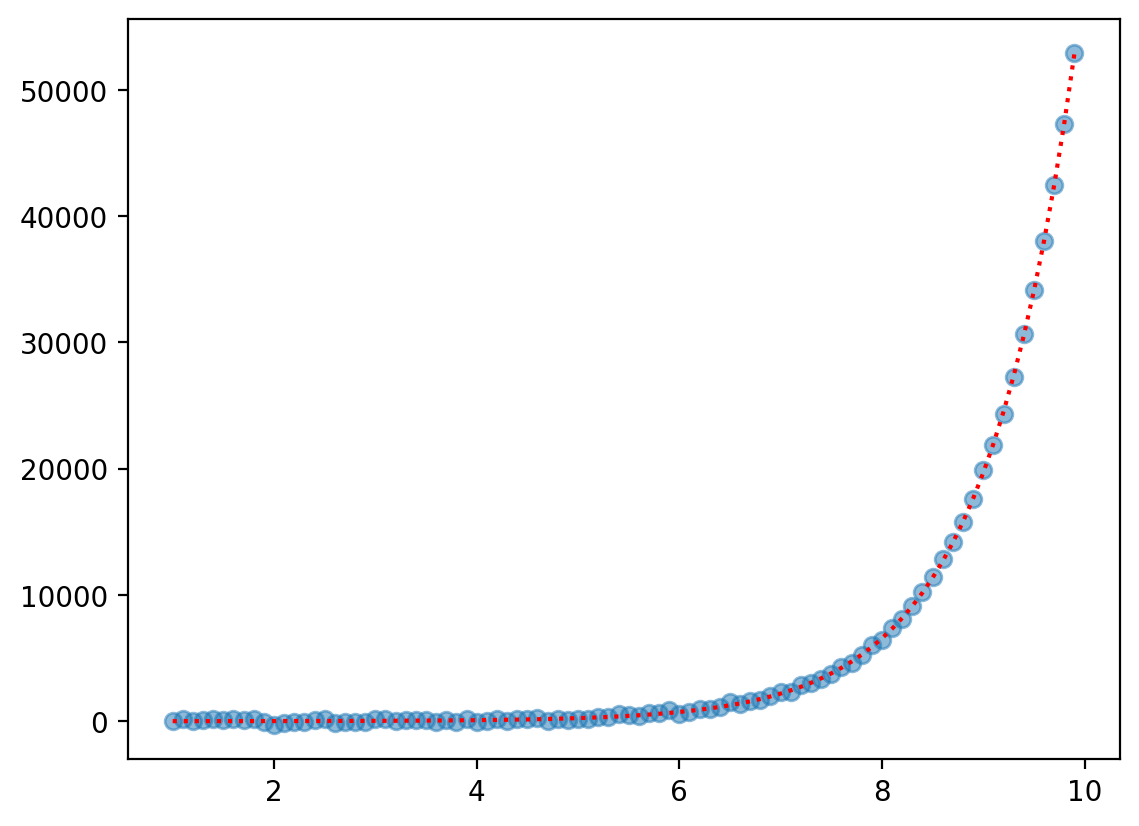

In [6]:
X = np.arange(1, 10, .1)
b0, b1 = 0, 3
y = b0 + b1 ** X
y_err = np.random.normal(scale = 100, size = len(X))
plt.scatter(X, y + y_err, alpha = .5)
plt.plot(X, y, linestyle = "dotted", color = "red")

##### Detour: Exponential vs. quadratic

- Both expontentials and quadratic have an **increasing rate of growth**.  
- Exactly *how fast* depends on $\beta_1$.

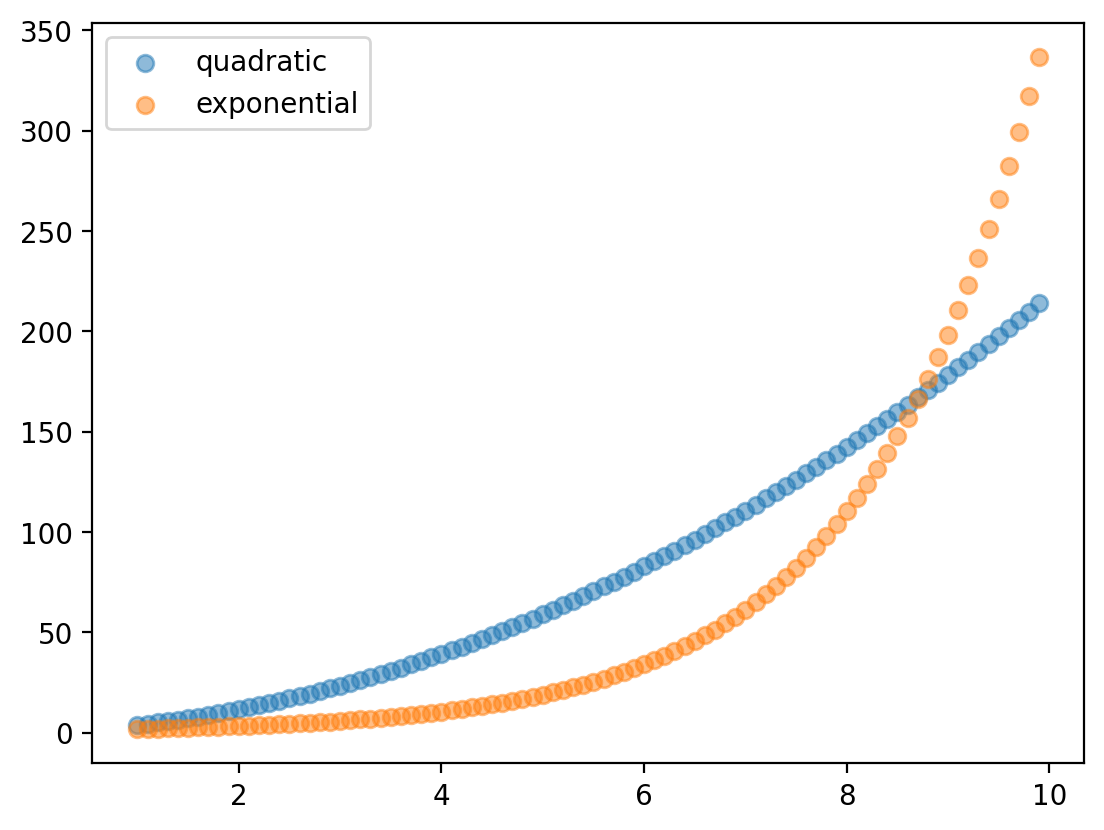

In [7]:
X = np.arange(1, 10, .1)
b0, b1, b2 = 0, 1.8, 2
y_quad = b0 + b1 * X + b2 * X ** 2 
y_exp = b0 + b1 ** X
plt.scatter(X, y_quad, alpha = .5, label = "quadratic")
plt.scatter(X, y_exp, alpha = .5, label = "exponential")
plt.legend()

#### Non-linear function 4: Logistic

The logistic (or *sigmoidal*) function produces a classic **S-shaped curve**.

$f(x) = \frac{e^{\beta_0 + \beta_1 * X}}{1 + e^{\beta_0 + \beta_1 * X}}$

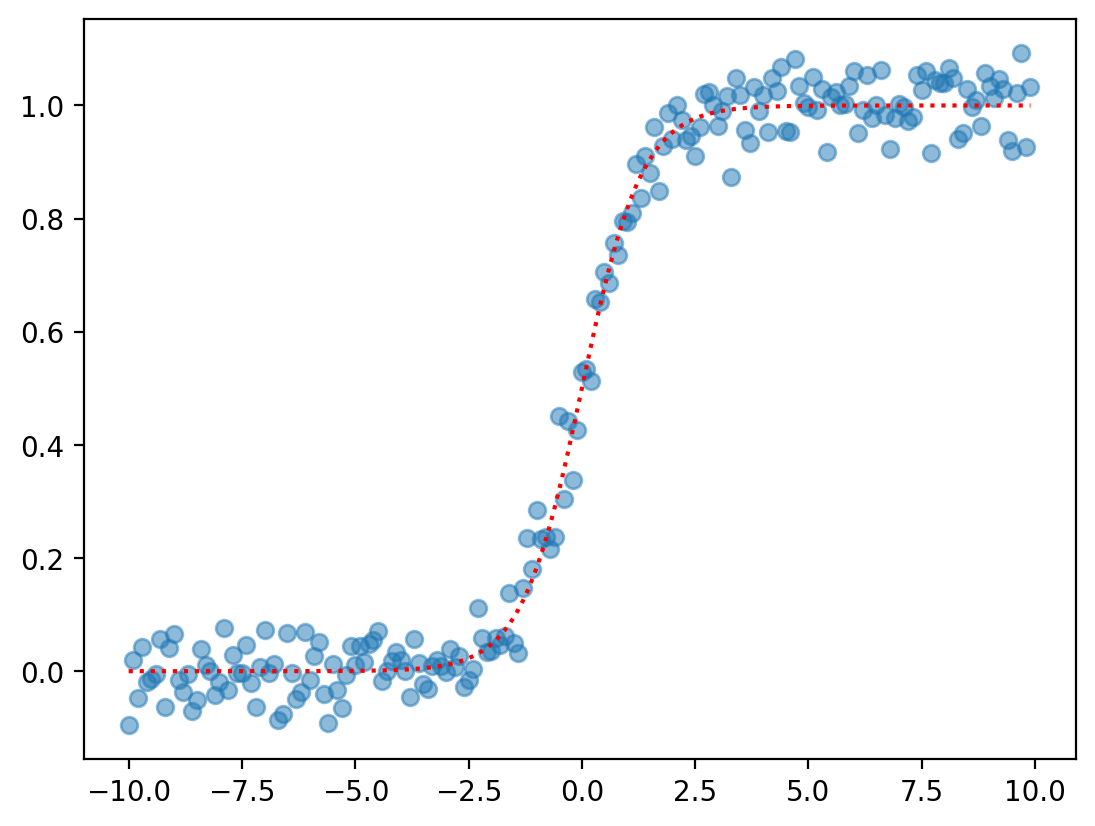

In [8]:
X = np.arange(-10, 10, .1)
b0, b1 = 0, 1.5
y = (np.exp(b1 * X + b0))/(1 + np.exp(b1 * X + b0))
y_err = np.random.normal(scale = .05, size = len(X))
plt.scatter(X, y + y_err, alpha = .5)
plt.plot(X, y, linestyle = "dotted", color = "red")

## Non-linear functions in...linear regression?

### Rethinking the linear assumption

- The **linear assumption** is almost always an over-simplification.  
- Yet the **linear equation** is an incredibly useful approach to statistical modeling.  
- Is there a way to preserve the benefits of linear modeling while accommodating non-linear relationships?

One solution is **polynomial regression**. 

### Introducing polynomial regression

> **Polynomial regression** refers to replacing the standard *linear model* with a polynomial function, whose coefficients can still be estimated using **least squares**.

The standard linear model looks like:

$Y = \beta_0 + \beta_1X + \epsilon$

A **polynomial equation** might look like:

$Y = \beta_0 + \beta_1X + \beta_2X^2 + ... + \beta_pX^p + \epsilon$

Where $d$ is the **order** of the polynomial.

### Same feature, different transformations

- In polynomial regression, we enter the same predictor ($X$) multiple times in the same model.  
- However, we **transform** that predictor according to the order ($p$) of our polynomial.

Typically, we limit $p ≤ 4$ to prevent **overfitting**.

### Polynomial regression in action

To start, let's consider a dataset with a clearly non-linear relationship: `gdp_cap ~ year` in `Vietnam`.

<Axes: xlabel='year', ylabel='gdp_cap'>

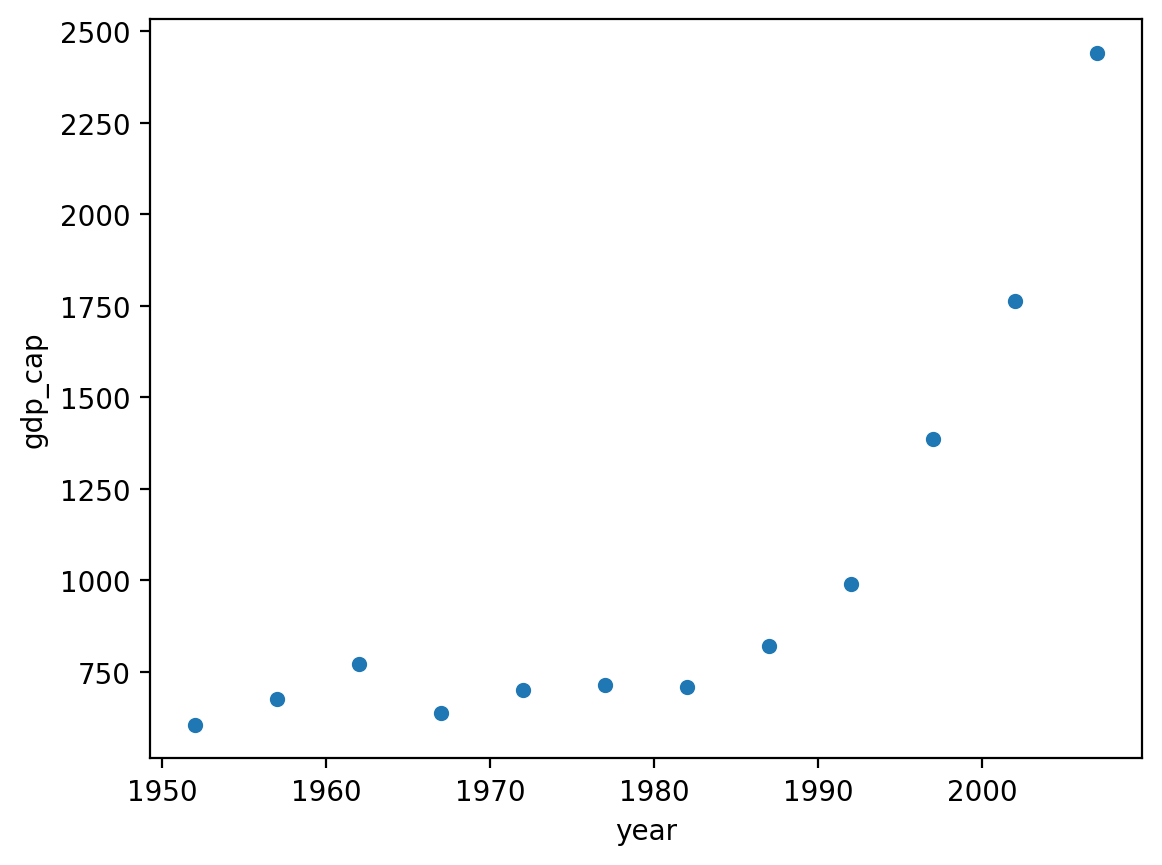

In [9]:
df_gapminder = pd.read_csv("data/viz/gapminder_full.csv")
df_vietnam = df_gapminder[df_gapminder['country'] == "Vietnam"]
sns.scatterplot(data = df_vietnam, x = "year", y = "gdp_cap")

#### Linear regression is unsuitable

First, let's build a *linear model* and see how it does.

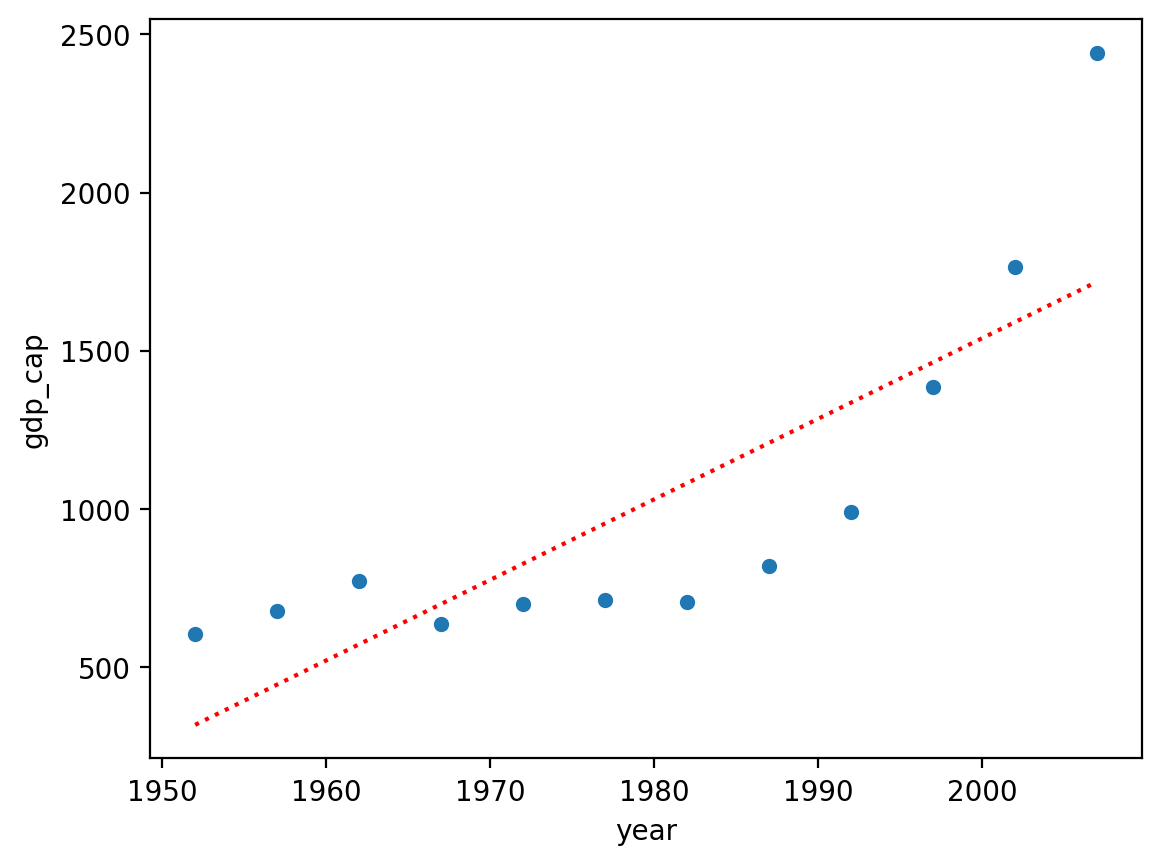

In [10]:
mod_linear = smf.ols(data = df_vietnam, formula = "gdp_cap ~ year").fit()
sns.scatterplot(data = df_vietnam, x = "year", y = "gdp_cap")
plt.plot(df_vietnam['year'], mod_linear.predict(), linestyle = "dotted", color = "red")

#### Inspecting our residuals

- One way to identify **non-linearity** is to inspect your residuals.  
- Here, it's clear that our residuals are not **normally distributed** around values of $X$. 

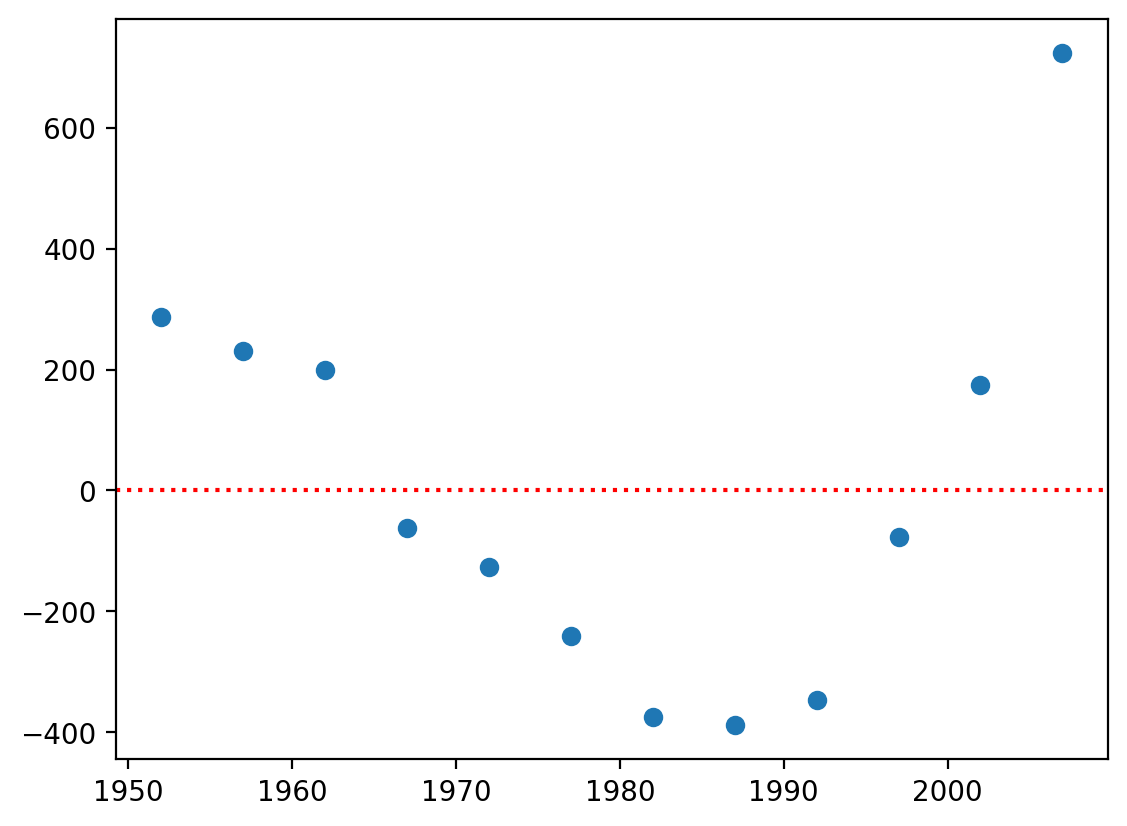

In [11]:
plt.scatter(df_vietnam['year'], mod_linear.resid)
plt.axhline(y = 0, linestyle = "dotted", color = "red")

#### Check-in

What does the *current* linear equation look like? How could we transform it to a polynomial function?

In [12]:
### Your code here

#### "Upgrading" our model

Our ordinary regression model looks like:

$GDP = \beta_0 + \beta_{1}*Year + \epsilon$

We can **upgrade** it to a $2$-degree polynomial like so:

$GDP = \beta_0 + \beta_{1}*Year + \beta_{2}*Year^2 + \epsilon$

#### Polynomial functions in `statsmodels`: approach 1

As a first step, we can simply create a new **variable**, which is $Year^2$, and insert it into the regression equation.

In [13]:
df_vietnam['year_sq'] = df_vietnam['year'].values ** 2
mod_poly = smf.ols(data = df_vietnam, formula = "gdp_cap ~ year + year_sq").fit()

/var/folders/pn/5zbmv0cj31v6hmyh53njhmdw0000gn/T/ipykernel_1744/2027117275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vietnam['year_sq'] = df_vietnam['year'].values ** 2


##### Inspecting predictions

Much better!

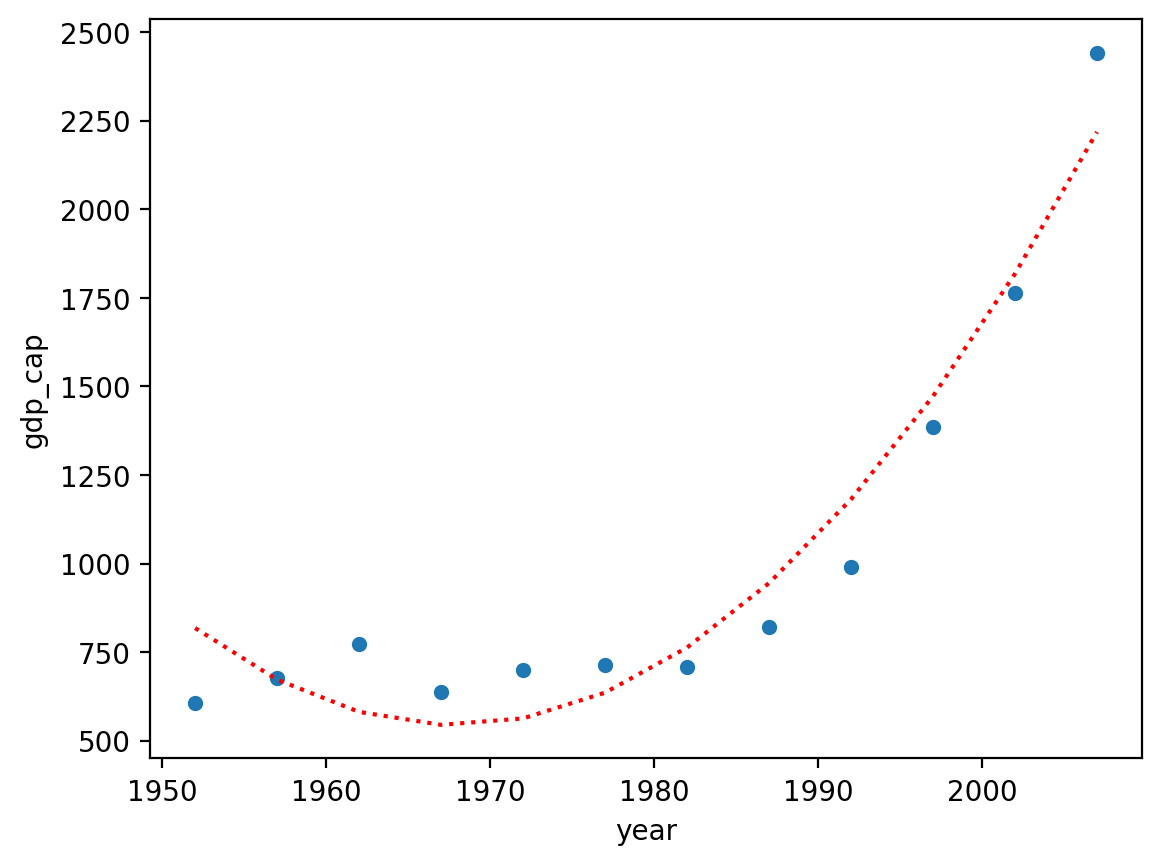

In [14]:
sns.scatterplot(data = df_vietnam, x = "year", y = "gdp_cap")
plt.plot(df_vietnam['year'], mod_poly.predict(), linestyle = "dotted", color = "red")

##### Inspecting coefficients

On the other hand, our **coefficients** are much harder to interpret...no longer obeys the simple interpretation of linera regression.

In [15]:
mod_poly.params

Intercept    4.228126e+06
year        -4.296675e+03
year_sq      1.091724e+00
dtype: float64

#### Polynomial functions in `statsmodels`: approach 2

Rather than having to a create new *variable* for each $p$-degree, we can do this directly in `statsmodels` using a syntactic approach called [patsy](https://stackoverflow.com/questions/32484244/reciprocals-in-patsy/36539093#36539093):

```python
formula = "y ~ x + I(x**2)"...
```

In [16]:
mod_poly = smf.ols(data = df_vietnam, formula = "gdp_cap ~ year + I(year ** 2)").fit()
mod_poly.params ## Exactly the same as before

Intercept       4.228126e+06
year           -4.296675e+03
I(year ** 2)    1.091724e+00
dtype: float64

##### Inspecting predictions

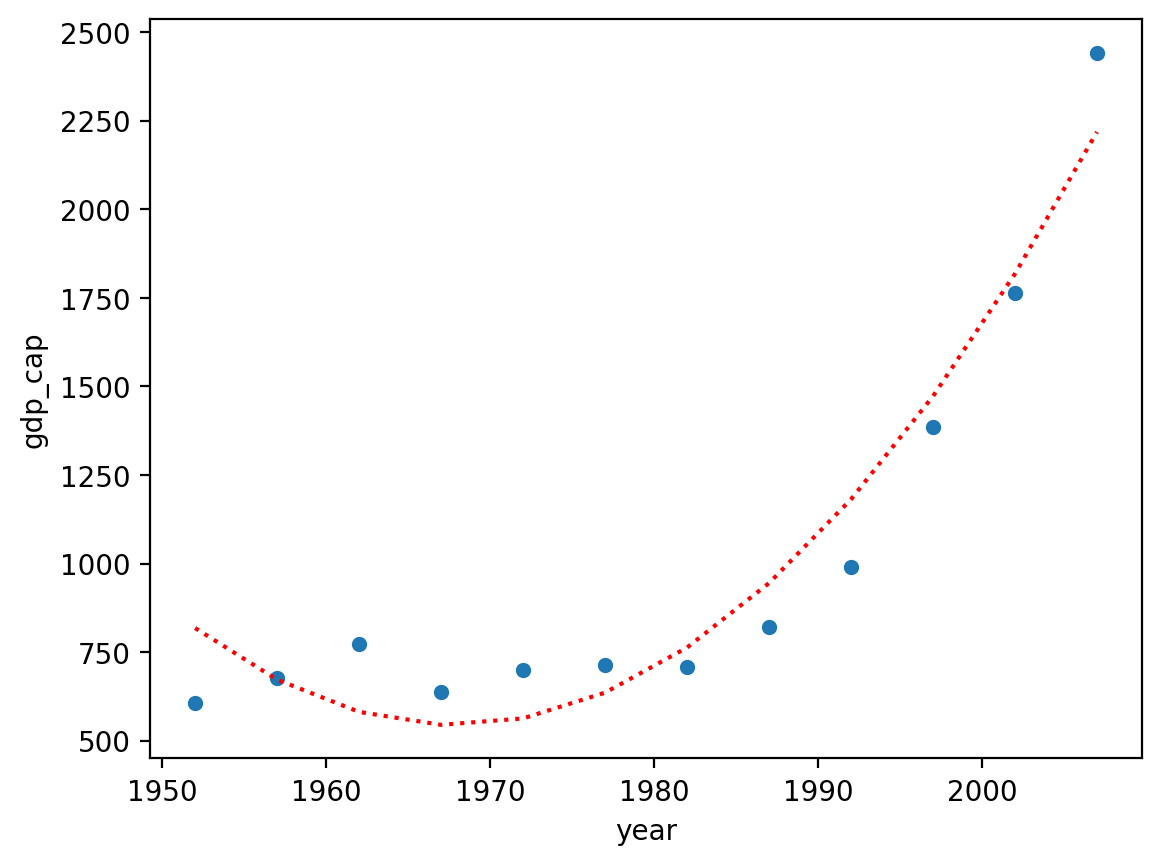

In [17]:
sns.scatterplot(data = df_vietnam, x = "year", y = "gdp_cap")
plt.plot(df_vietnam['year'], mod_poly.predict(), linestyle = "dotted", color = "red")

#### Why `I(x ** n)` is easier

If we want to create a higher-order polynomial, it's much easier to just add more terms using `I(x ** n)`.

In [18]:
mod_p3 = smf.ols(data = df_vietnam, formula = "gdp_cap ~ year + I(year ** 2) + I(year ** 3)").fit()

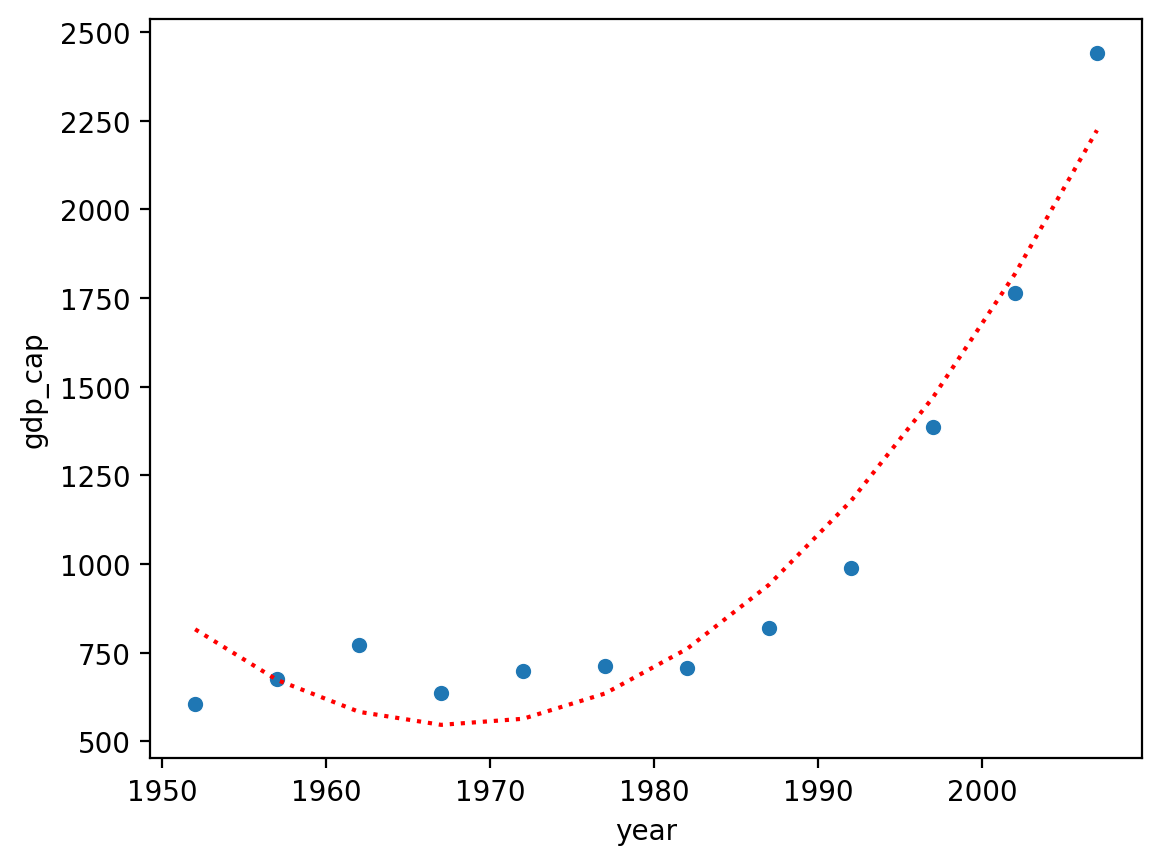

In [19]:
sns.scatterplot(data = df_vietnam, x = "year", y = "gdp_cap")
plt.plot(df_vietnam['year'], mod_p3.predict(), linestyle = "dotted", color = "red")

## Can $p$ be too big?

> A higher-order polynomial will *always* produce a slightly better fit, because it has more **degrees of freedom**.

However, this **flexibility** comes with a trade-off:

- Higher-order polynomials are harder to **interpret**.  
- Higher-order polynomials are more likely to **overfit** to "noise" in our data.

### Overfitting in action

To demonstrate overfitting, we can first produce a simple but noisy linear relationship.

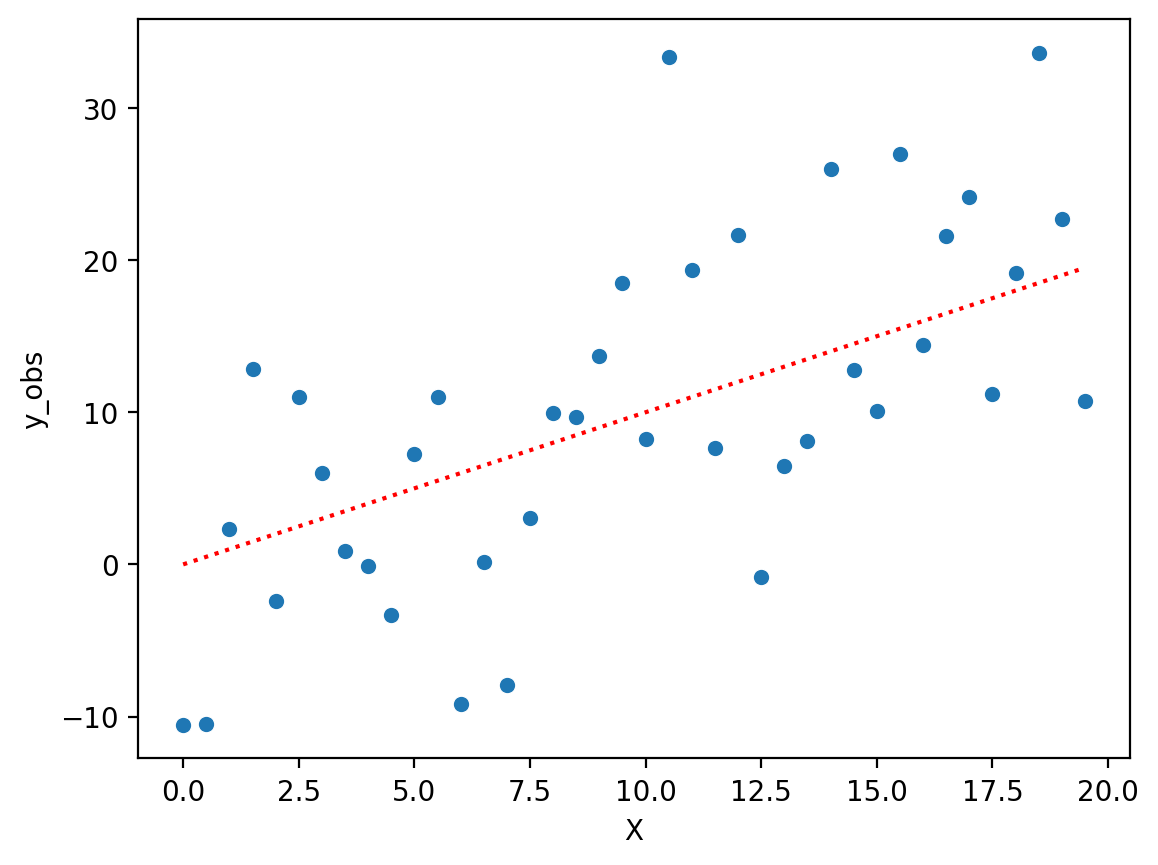

In [20]:
X = np.arange(0, 20, .5)
y = X
err = np.random.normal(scale = 8, size = len(X))
df = pd.DataFrame({'X': X, 'y_true': y, 'y_obs': y + err})
sns.scatterplot(data = df, x = "X", y = "y_obs")
plt.plot(X, y, linestyle = "dotted", color = "red")

### Fitting a complex polynomial

Now, let's fit a very **complex** polynomial to these data––even though we know the "true" relationship is linear (albeit noisy).

In [21]:
### Very complex polynomial
mod_p10 = smf.ols(data = df, formula = "y_obs ~ X + I(X**2) + I(X**3) + I(X**4) + I(X**5) + I(X**6)  + I(X**7)  + I(X**8)  + I(X**9)  + I(X**10)").fit()

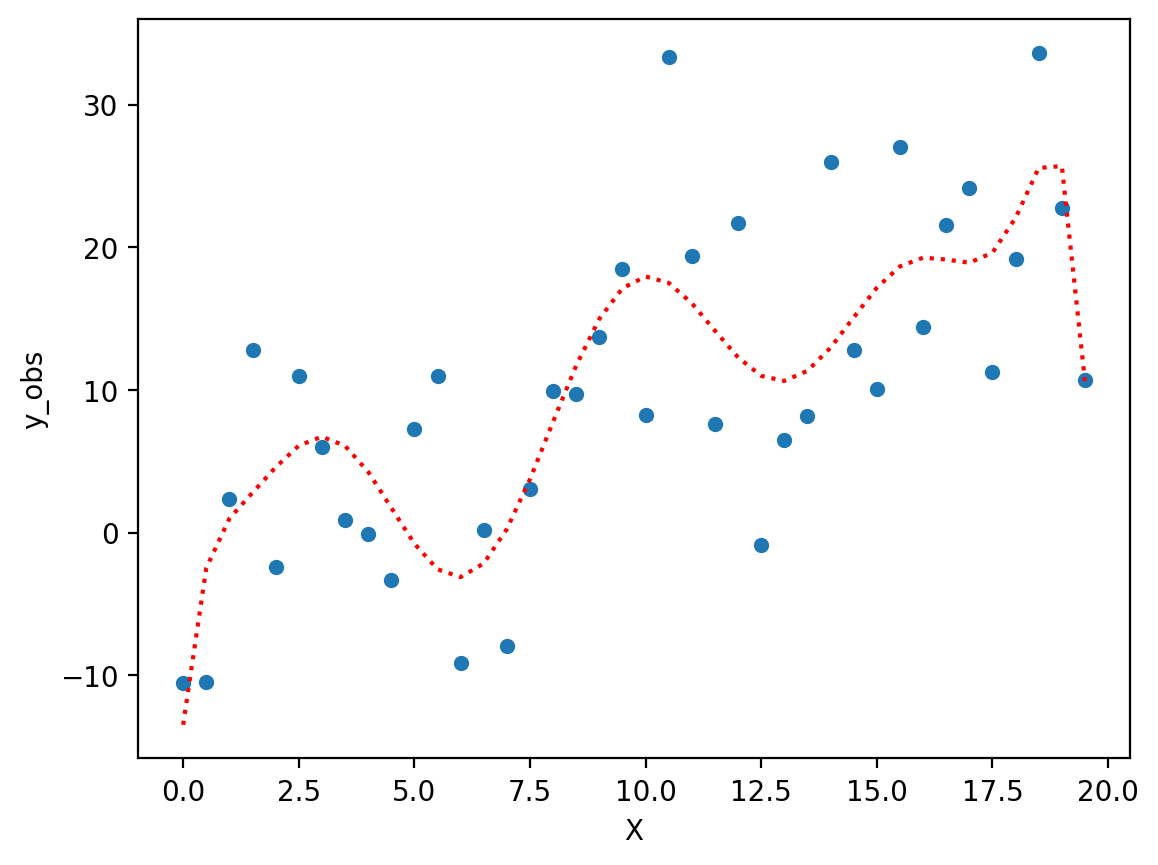

In [22]:
### Now we have a "better" fit––but it doesn't really reflect the true relationship.
sns.scatterplot(data = df, x = "X", y = "y_obs")
plt.plot(X, mod_p10.predict(), linestyle = "dotted", color = "red")

### Coming up: the *bias-variance trade-off*

In general, statistical models display a **trade-off** between their:

- **Bias**: high "bias" means a model is not very flexible.  
  - E.g., linear regression is a very *biased* model, so it cannot fit non-linear relationships. 
- **Variance**: high "variance" means a model is more likely to overfit. 
  - E.g., polynomial regression is very flexible, but it's more likely to fit to noise––exhibiting poor **generalization** across samples.
  
We'll explore these concepts much more soon!

## Conclusion

- Many relationships are *non-linear*.  
- We can **extend** linear regression to these non-linear relationships using **polynomial functions**. 
- A higher-order polynomial is more **flexible** and can accommodate more relationships.  
- However, *too much flexibility* can lead to **overfitting**.